# Lab 7: Pitch tracking and modifications

## Part 1: Making a pitch tracker

In this section we will design a pitch tracker. We will apply it on this sound file:

[https://drive.google.com/uc?export=download&id=1gB1MlHQJiXRJRYAauWxdJDcRoYs8q0oM ]

We want to find the pitch of the singing over time, as well as if the sound is pitched or not at any point in time. To do so we will design an autocorrelation pitch tracker.
Do the following:
1. Perform an STFT of the sound
2. Using the DFT representation of each frame compute the frame’s autocorrelation
3. Invert each frame’s autocorrelation back to the time domain
4. Find the first peak after the main peak (which will be at the first element)
    - We will only look for pitches between 100 and 300Hz
	- Which means that you only need to look for a peak at a specific range
5. If the peak is more than 70% of the main peak we have a pitched frame
	- Otherwise it is an un-pitched frame
Plot the pitch value over time and see if it correlates with what you are hearing (we also have the correct plot in the lecture slides).


In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np

In [2]:
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

In [3]:
def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # Zero padding to front and end of the input
    zero_padding = np.zeros(dft_size)
    x = np.append(zero_padding, input_sound)
    x = np.append(x, zero_padding)

    # Segment into shorter frames
    frames = []
    for i in range(0, len(x)-dft_size, hop_size):
        # Apply analysis window
        frames.append(x[i:i+dft_size] * window)

    f = []
    for frame in frames:
        freq_vec = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        if len(f) == 0:
            f = freq_vec
        else:
            f = np.hstack((f, freq_vec))

    # Return a complex-valued spectrogram (frequencies x time)
    return f

def plot_spectrogram(x, X, fs, title=''):
    time_axis = np.linspace(0, len(x)/fs, X.shape[1])
    freq_axis = np.linspace(0, fs/2, X.shape[0])
    freq_abs = np.absolute(X)

    plt.pcolormesh(time_axis, freq_axis, np.log(freq_abs+np.e), cmap='Blues')

    plt.title(title)
    plt.xlabel('Time (sec)')
    plt.ylabel('Freq (Hz)')

    plt.xlim(0, len(x)/fs)
    plt.ylim(0, 5000)

    plt.show()

def autocorrelation(X):
    X_conj = np.conj(X)
    C = X_conj * X
    
    c = []
    for i in range(C.shape[1]):
        c.append(np.fft.irfft(C[:, i]))
    c = np.array(c)
    
    return c

def find_period_peaks(c, lowest_pitch, highest_pitch, thresold):
    lowest_index = fs // int(highest_pitch)
    highest_index = fs // int(lowest_pitch)
    indices = np.arange(lowest_index, highest_index)

    period_peaks = []
    for i in range(c.shape[0]):
        peaks, _ = signal.find_peaks(c[i])
        mask = np.isin(indices, peaks)
        peaks_in_range = indices[mask]

        for peak in peaks_in_range:
            if c[i][peak] > c[i][0] * thresold:
                freq = int(fs / peak)
                period_peaks.append([i * hop_size / fs, freq])
                # Break after finding the first period peak
                break
    period_peaks = np.array(period_peaks)
    
    return period_peaks

In [4]:
fs, x = wavfile.read('data/beauty.wav')

In [5]:
dft_size = 1024
hop_size = 256
zero_pad = 0
stft_window = signal.hann(dft_size, sym=False)

X = stft(x, dft_size, hop_size, zero_pad, stft_window)
c = autocorrelation(X) # shape=(frame, dft_size)

In [6]:
thresold = 0.7 # 70% of the main peak
lowest_pitch = 100
highest_pitch = 300

period_peaks = find_period_peaks(c, lowest_pitch, highest_pitch, thresold)

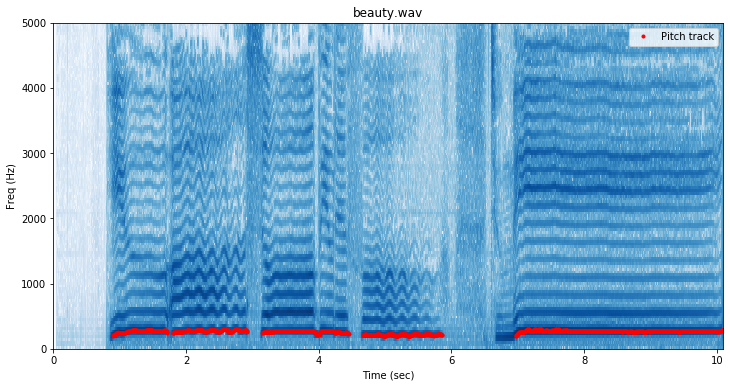

In [7]:
time_axis = np.linspace(0, len(x)/fs, X.shape[1])
freq_axis = np.linspace(0, fs/2, X.shape[0])
freq_abs = np.absolute(X)
plt.figure(figsize=(12, 6))

plt.pcolormesh(time_axis, freq_axis, np.log(freq_abs+np.e), cmap='Blues')
plt.plot(period_peaks[:, 0], period_peaks[:, 1], 'ro', markersize=3, label='Pitch track')

plt.title('beauty.wav')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.legend()

plt.xlim(0, len(x)/fs)
plt.ylim(0, 5000)

plt.show()

sound(x, fs)

## Part 2. Changing pitch 

We will now correct the pitch of that last horrible note. We will use the zero crossing method to find where the periods are and then we will shift them appropriately to create a pitch of 274Hz.

1. Get samples 303,000 to 445,000 which is the horrible part.

2. Lowpass filter to facilitate the zero crossing finding

    - Pick an appropriate cutoff frequency that will help
    – Use the ```scipy.signal.filtfilt()``` function which will not time-shift the input
    
3. Find the zero crossing points which should be the starts of each period

4. For each period get the signal from the previous period’s start till this period’s end

5. Window that signal with a Hann window to remove any discontinuities

6. Overlap add each of the above at a rate appropriate for 274Hz

Play the sound, does it sound more in tune? (it better!)

In [8]:
# Get samples
x_horrible =  x[303000:445000]

# Apply lowpass filter
b, a = signal.butter(4, 300, 'lowpass', fs=fs)
x_lowpass = signal.filtfilt(b, a, x_horrible)

# Find the zero crossing points
zero_crossing_indices = np.where(np.diff(np.sign(x_lowpass)))[0]
# Start of each period
zero_crossing_indices = zero_crossing_indices[::2]

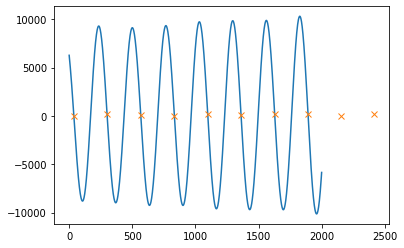

In [9]:
plt.plot(x_lowpass[:2000])
plt.plot(zero_crossing_indices[:10], x_lowpass[zero_crossing_indices[:10]], 'x')
plt.show()

In [10]:
periods = []
length = 2
for i in range(zero_crossing_indices.shape[0]-length):
    start_index = zero_crossing_indices[i]
    end_index = zero_crossing_indices[i+length]
    
    x_seg = x_horrible[start_index:end_index]
    window = signal.hann(x_seg.shape[0], sym=False)
    x_seg = x_seg * window
    periods.append(x_seg)

In [11]:
x_horrible_tuned = np.zeros(x_horrible.shape)
# Initialize values before the first zero crossing point
x_horrible_tuned[:zero_crossing_indices[0]] += x_horrible[:zero_crossing_indices[0]]
current_index = zero_crossing_indices[0]
tuned_freq = 274

for i in range(len(periods)):
    length = len(periods[i])
    if current_index + length > x_horrible_tuned.shape[0]:
        length = x_horrible_tuned.shape[0] - current_index
        if length <= 0:
            break
    x_horrible_tuned[current_index:current_index+length] += periods[i][:length]
    # randomly pick frequency around 274Hz
    add_index = fs // int(tuned_freq + 12 * (np.random.random()-0.5))
    current_index += add_index
    
x_tuned = np.append(x[:303000], x_horrible_tuned)
X_tuned = stft(x_tuned, dft_size, hop_size, zero_pad, stft_window)

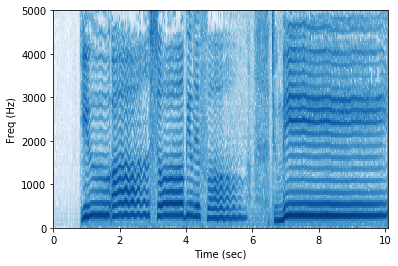

In [12]:
plot_spectrogram(x, X, fs)
sound(x, fs)

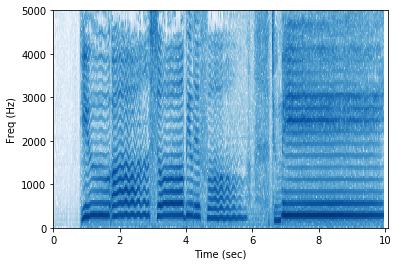

In [13]:
plot_spectrogram(x_tuned, X_tuned, fs)
sound(x_tuned, fs)